In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
from scipy import stats
import warnings

%matplotlib inline

In [2]:
short_cadence_xmatch = '../data/tess_gaia_magnitudes.csv'

data = pd.read_csv(short_cadence_xmatch)

(-90, 90)

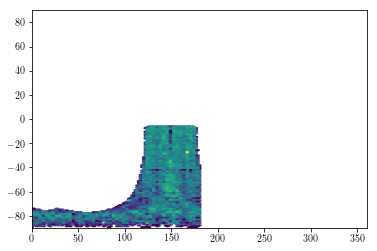

In [3]:
plt.hexbin(data['ecl_lon']-180,data['ecl_lat'],mincnt=1,bins='log')
plt.xlim(0,360)
plt.ylim(-90,90)

In [4]:
#Now let's try to isolate massive stars using MIST. Take all isochrones with initial mass > 8
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

MWnames = ('EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',
           'log_g','log_L','[Fe/H]_init','[Fe/H]','WISE_W1','WISE_W2','WISE_W3',
           'WISE_W4','phase')

Mfile = '../../GaiaSprintMassive/WISE/data/MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_massive = mist[(mist['initial_mass'] >= 8)]
mist_MS = mist[(mist['EEP'] >= 202)&(mist['EEP']<=454)]

#Now, in each color bin, give me the color and magnitude of the faintest star.
col_bins = np.linspace(-0.25,3,100)
min_cols = []
min_mags = []

for i,left in enumerate(col_bins[:-1]):
    mist_subset = mist_massive[(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']>left)&
                               (mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']<=col_bins[i+1])]
    min_point = mist_subset[mist_subset['Gaia_G_DR2Rev']==np.max(mist_subset['Gaia_G_DR2Rev'])]
    if len(min_point) != 0:
        min_cols.append((min_point['Gaia_BP_DR2Rev'].values-min_point['Gaia_RP_DR2Rev'].values)[0])
        min_mags.append((min_point['Gaia_G_DR2Rev'].values)[0])

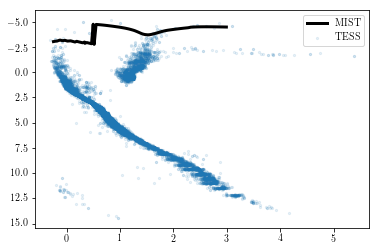

In [5]:
plt.scatter(data['(BP_RP)_0'],data['M_G'],s=5,alpha=0.1,label='TESS')
plt.plot(min_cols,min_mags,'-k',lw=3,label='MIST')
plt.gca().invert_yaxis()
plt.legend()

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    minmag = np.interp(data['(BP_RP)_0'], min_cols, min_mags)

    massive = data[data['M_G'] <= minmag]
    massive.sort_values('phot_g_mean_mag',inplace=True)

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    customSimbad = Simbad()
    customSimbad.add_votable_fields('mk', 'otype', 'sptype')
    common_names = []
    mks = []
    otypes = []
    sptypes = []
    for i,row in massive.iterrows():
        coords = coord.SkyCoord(row['ra'],row['dec'],frame='icrs',unit=u.deg)
        result_table = customSimbad.query_region(coords, radius=2*u.arcsec)
        try:
            common_name = result_table['MAIN_ID'][0].decode('utf8')
            mk = result_table['MK_Spectral_type'][0].decode('utf8')
            otype = result_table['OTYPE'][0].decode('utf8')
            sptype = result_table['SP_TYPE'][0].decode('utf8')
            common_names.append(common_name)
            mks.append(mk)
            otypes.append(otype)
            sptypes.append(sptype)
        except TypeError:
            common_names.append(np.nan)
            mks.append(np.nan)
            otypes.append(np.nan)
            sptypes.append(np.nan)
    massive['CommonName'] = common_names
    massive['MKType'] = mks
    massive['SimbadOType'] = otypes
    massive['SpT'] = sptypes

In [8]:
np.savetxt('unique_names.txt',np.unique(massive['CommonName']),fmt='%s')

In [9]:
massive.to_csv('massive_2min.csv')

N Car is A0II

HD 210767 is supposed to be F0IV, so this is a revision of previous distances to it. Its also high proper motion, so that might be screwing with us.
HD  64811 is a B4III

HD  33599 is a Be star

S Dor is S Dor (LBV)

HD 270386 is M4 D? Probs AGB?

HD 270046 is a G5 Supergiant?!

CD-46   529 is high proper motion

CD-56   152 is a Be star

HD 269582 is WN10h (but in one of the MCs, so it might be a weird lightcurve to parse)

HD 268687 is F6 Supergiant! Also in the MCs

DD Mic is a symbiotic star, M0.2e

all else are LPVs

In [10]:
np.array(massive.columns)

array(['Unnamed: 0', 'a_g_percentile_lower', 'a_g_percentile_upper',
       'a_g_val', 'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_gof_al',
       'astrometric_matched_observations', 'astrometric_n_bad_obs_al',
       'astrometric_n_good_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_obs_al', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_pseudo_colour',
       'astrometric_pseudo_colour_error', 'astrometric_sigma5d_max',
       'astrometric_weight_al', 'b', 'bp_g', 'bp_rp', 'camera', 'ccd',
       'datalink_url', 'dec', 'dec.1', 'dec_error', 'dec_parallax_corr',
       'dec_pmdec_corr', 'dec_pmra_corr', 'designation', 'dist',
       'duplicated_source', 'e_bp_min_rp_percentile_lower',
       'e_bp_min_rp_percentile_upper', 'e_bp_min_rp_val', 'ecl_lat',
       'ecl_lon', 'epoch_photometry_url', 'flame_flags',
       'frame_rotator_object_type', 'g_rp', 'l', 'lum_percentile_lower',
       'l

```python
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig = plt.figure(figsize=(20,100))
    
    data_dir = '../data/massive_lcs/'
    for i,ticid in enumerate(np.unique(massive['ticid'])):
        files = glob(data_dir+'*{}*'.format(ticid))
        lcs = []
        for f in files:
            lc = Table.read(f, format='fits')
            lcs.append(lc)
        outlc = vstack(lcs)
        plt.scatter(outlc['TIME'],0.01*i+outlc['PDCSAP_FLUX']/np.nanmedian(outlc['PDCSAP_FLUX']),alpha=0.5)
    plt.savefig('art.png')
    ```

In [11]:
data_dir = '../data/massive_lcs/'

In [12]:
def get_lc_from_id(ticid, normalize=True, clean=True):
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        files = glob(data_dir+'*{}*'.format(ticid))
        if len(files) == 0:
            raise ValueError('TIC number not recognized')
        elif len(files) > 2:
            raise ValueError('TIC number ambiguous')
        else:
            lcs = []
            for f in files:
                lc = Table.read(f, format='fits')
                if clean:
                    lc = lc[lc['QUALITY'] == 0]
                if normalize:
                    lc['NormPDCSAP_FLUX'] = lc['PDCSAP_FLUX']/np.nanmedian(lc['PDCSAP_FLUX'])
                lcs.append(lc)
            outlc = vstack(lcs)
            return outlc.to_pandas()

In [13]:
def plot_lc_periodogram(ticid, phaseplot = False, dynamicplot = False, pmin = 0.1, pmax = 28.0, **kwargs):
    
    name = np.unique(massive['CommonName'][massive['ticid']==ticid])[0]
    spt = np.unique(massive['SpT'][massive['ticid']==ticid])[0]
    
    lc = get_lc_from_id(ticid, **kwargs)
    slc = lc.rolling(128, center=True).median()
    
    rtime = lc['TIME'].values
    if 'NormPDCSAP_FLUX' in lc.columns:
        rflux = lc['NormPDCSAP_FLUX'].values
    else:
        rflux = lc['PDCSAP_FLUX'].values
    
    time = rtime[~np.isnan(rflux)]
    flux = rflux[~np.isnan(rflux)]
    
    srtime = slc['TIME'].values
    if 'NormPDCSAP_FLUX' in lc.columns:
        srflux = slc['NormPDCSAP_FLUX'].values
    else:
        srflux = slc['PDCSAP_FLUX'].values
    
    stime = srtime[~np.isnan(srflux)]
    sflux = srflux[~np.isnan(srflux)]
    
    
    
    f, p = LombScargle(time, flux).autopower(minimum_frequency=1.0/pmax,
                                            maximum_frequency=1.0/pmin)
    
    sf, sp = LombScargle(stime, sflux).autopower(minimum_frequency=1.0/pmax,
                                            maximum_frequency=1.0/pmin)
    
    if (phaseplot and not dynamicplot) or (not phaseplot and dynamicplot):
        figheight = 18
        nax = 3
    elif phaseplot and dynamicplot:
        figheight = 24
        nax=4
    else: 
        figheight = 12
        nax=2
    
    fig, ax = plt.subplots(nax,figsize=(15,figheight))
    
    ax[0].scatter(time,flux,s=1,label='Data')
    ax[0].plot(stime,sflux,c='C1',alpha=0.7,label='128 Point Rolling Median')
    ax[0].set_xlim(0.9999*np.min(time),1.0001*np.max(time))
    ax[0].set_ylim(0.9999*np.min(flux),1.0001*np.max(flux))
    ax[0].set_xlabel('BJD - 2457000 [d]')
    ax[0].set_ylabel('PDCSAP\_FLUX [e-/s]')
    ax[0].set_title('{}: {}'.format(name,spt))
    ax[0].legend()
    
    ax[1].plot(1.0/f, p/np.max(p), label='Data')
    ax[1].plot(1.0/sf, sp/np.max(sp), label='128 Point Rolling Median')
    ax[1].set_xlabel('Period [d]')
    ax[1].set_ylabel('Normalized Power')
    
    if phaseplot:
        T_best = 1.0/(f[np.argmax(p)])
        phase = (time/T_best) % 1
        ax[2].scatter(phase,flux,s=1)
        ax[2].set_xlim(0,1)
        ax[2].set_ylim(0.9999*np.min(flux),1.0001*np.max(flux))
        ax[2].set_xlabel('Phase')
        ax[2].set_ylabel('PDCSAP\_FLUX [e-/s]')
    
    if dynamicplot:
        T_best = 1.0/(f[np.argmax(p)])
        phase = (time/T_best) % 1
        cycle = np.floor((time-np.min(time))/T_best)
        ybins = len(np.unique(cycle))
        xbins = 100
        H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  #idtime and idlat are the locations of each id1 value in time and latitude
        H = np.ma.masked_where(H==0, H) #masking where there was no data
        XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
        if phaseplot:
            iax = 3
        else:
            iax = 2
        colobj = ax[iax].pcolormesh(XX,YY,H.T)
        ax[iax].set_xlabel('Phase')
        ax[iax].set_ylabel('Cycle')
        plt.colorbar(colobj,ax=ax[iax],label='Median Flux')
    
    return fig, ax, lc

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


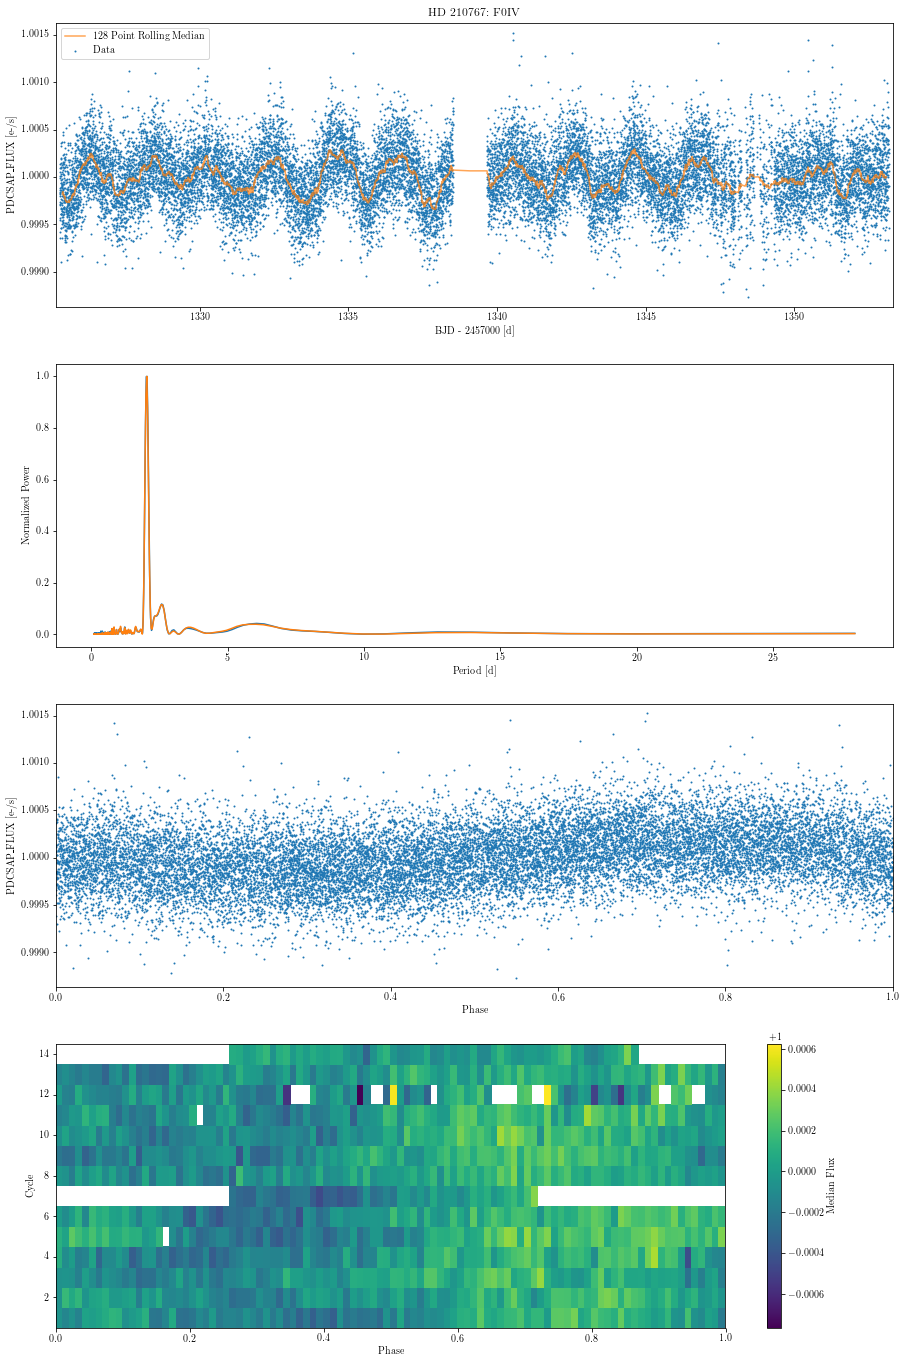

In [14]:
#HD 210767
lc = plot_lc_periodogram(278611926,phaseplot=True,dynamicplot=True)

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


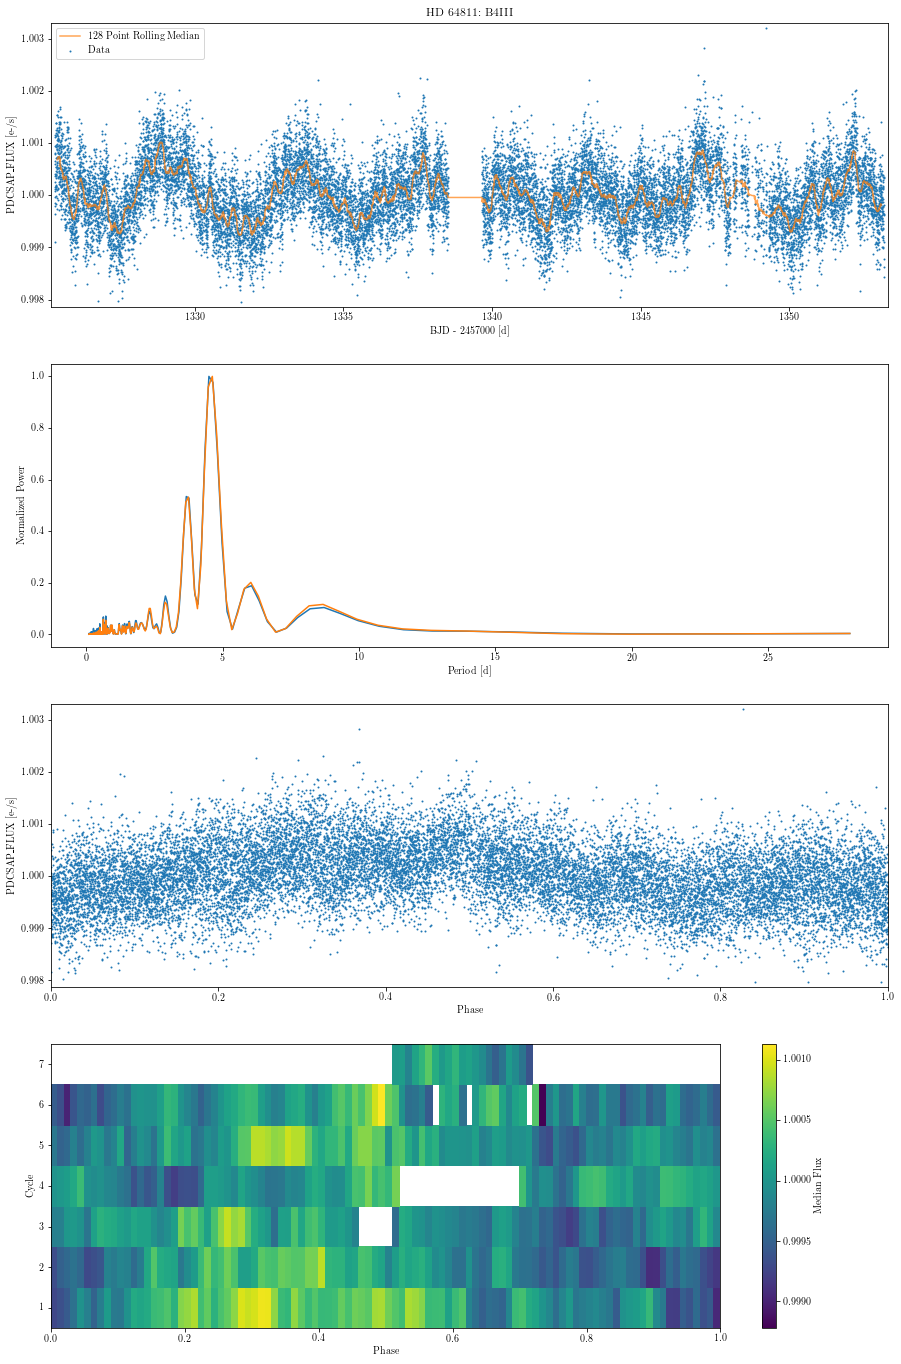

In [15]:
#HD 64811
lc = plot_lc_periodogram(410447919,phaseplot=True,dynamicplot=True)

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


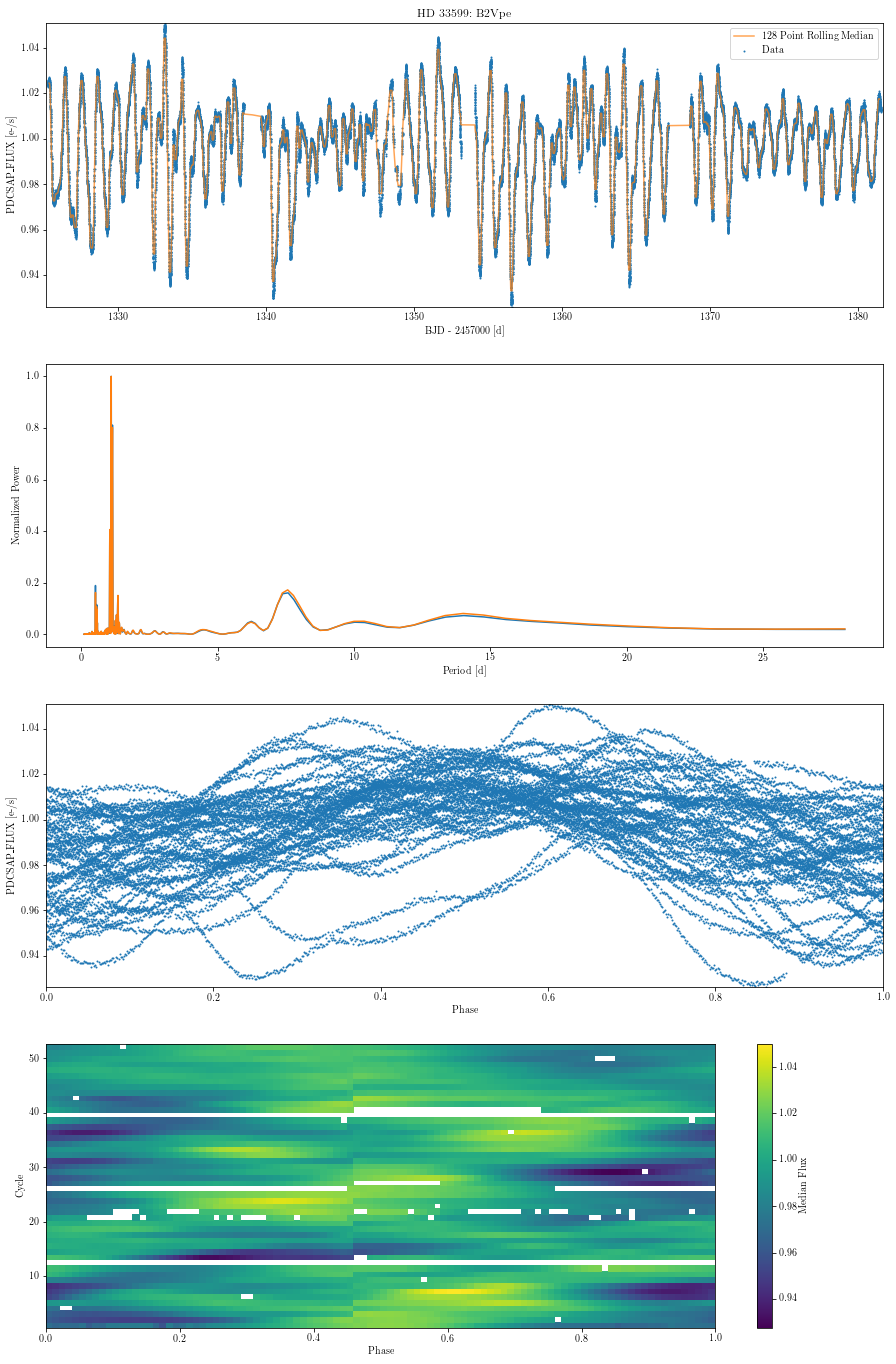

In [16]:
#HD 33599
lc = plot_lc_periodogram(55295028,phaseplot=True,dynamicplot=True)

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


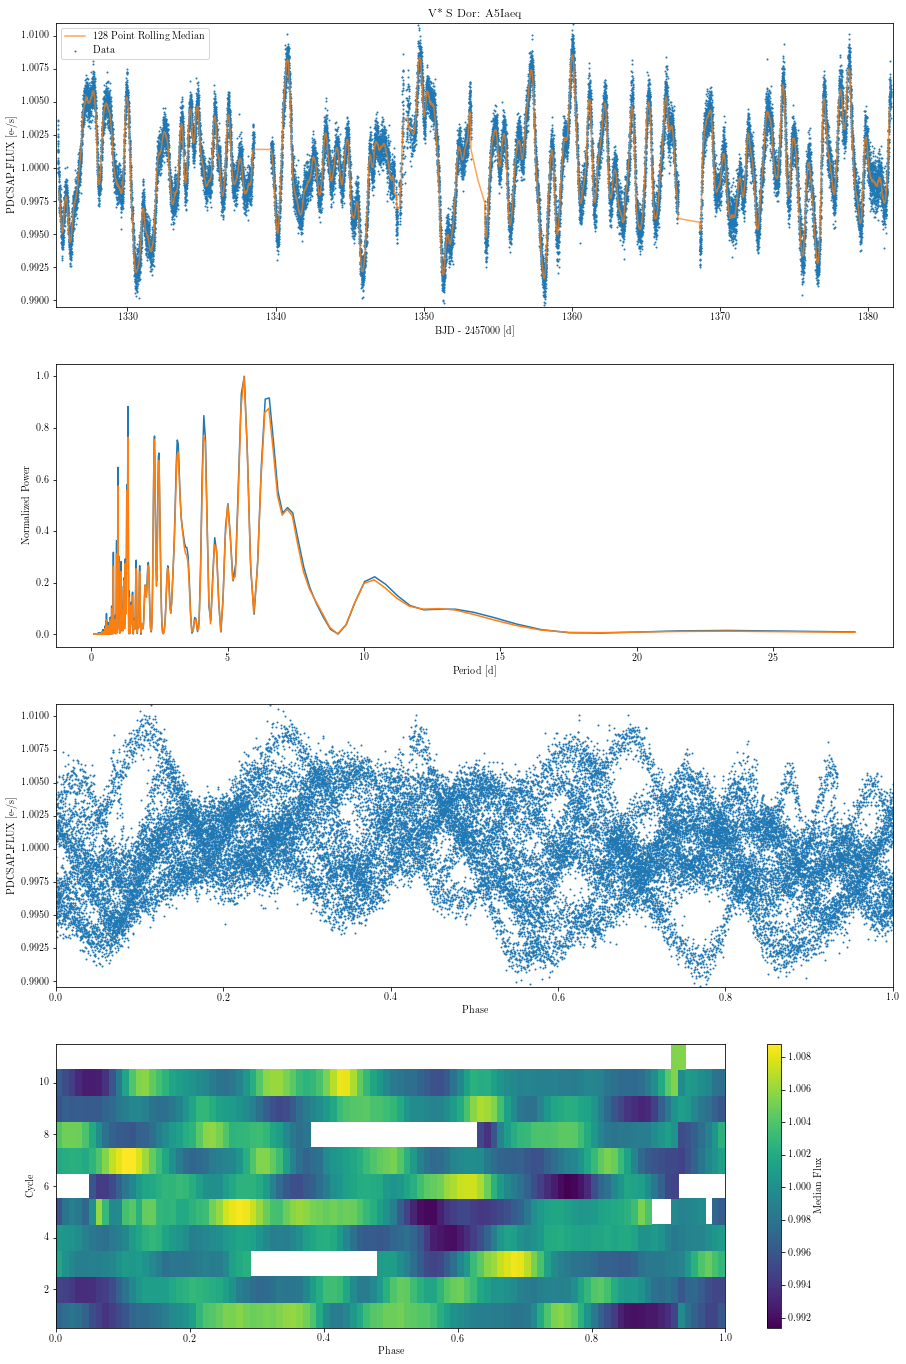

In [17]:
#S Dor
lc = plot_lc_periodogram(179305185,phaseplot=True,dynamicplot=True)

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


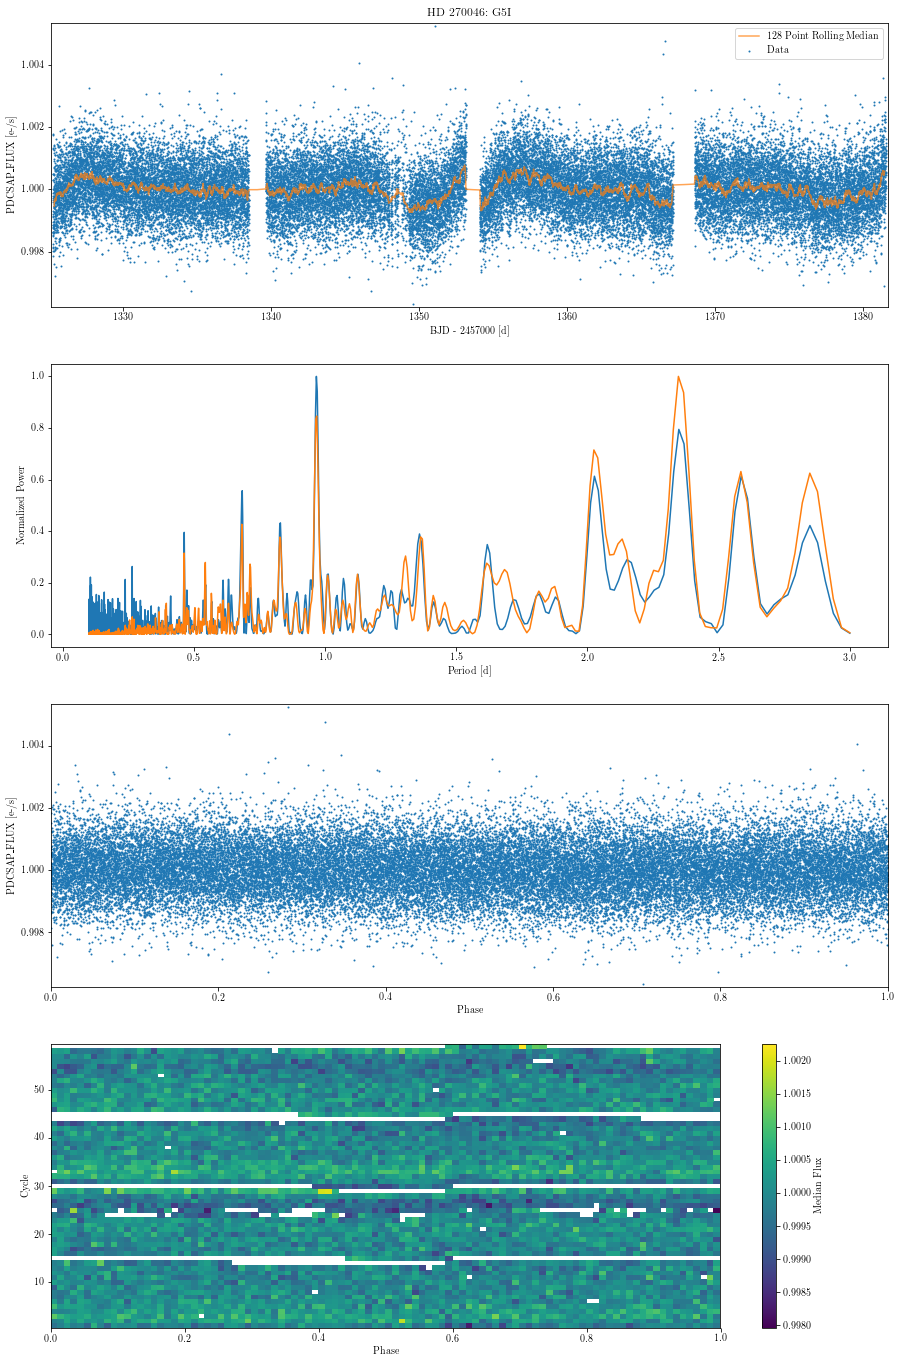

In [18]:
#HD 270046
lc = plot_lc_periodogram(389437365,phaseplot=True,dynamicplot=True,pmax=3)

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


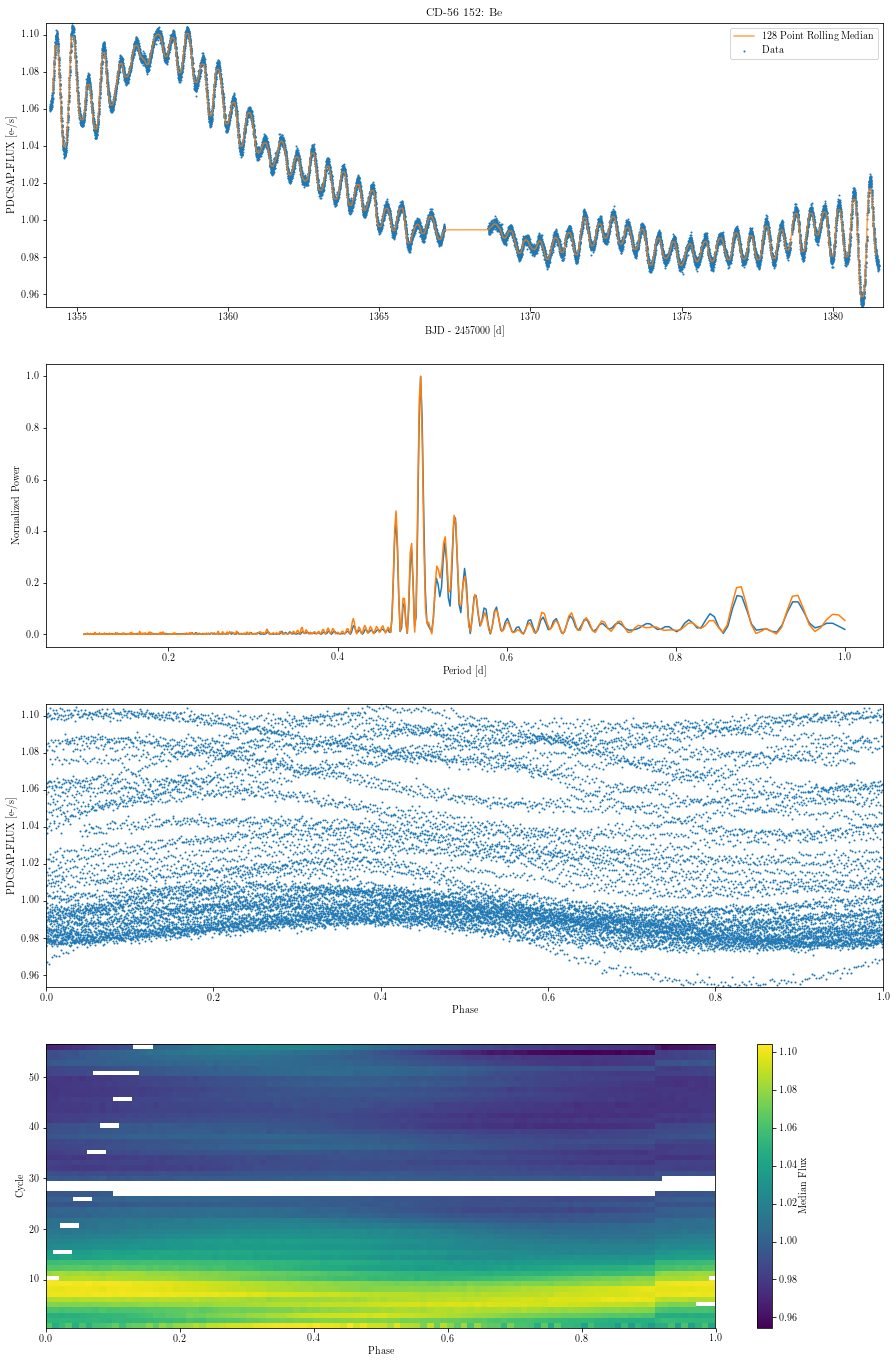

In [20]:
#CD-56 152
lc = plot_lc_periodogram(281741629,phaseplot=True,dynamicplot=True,pmax=1)

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


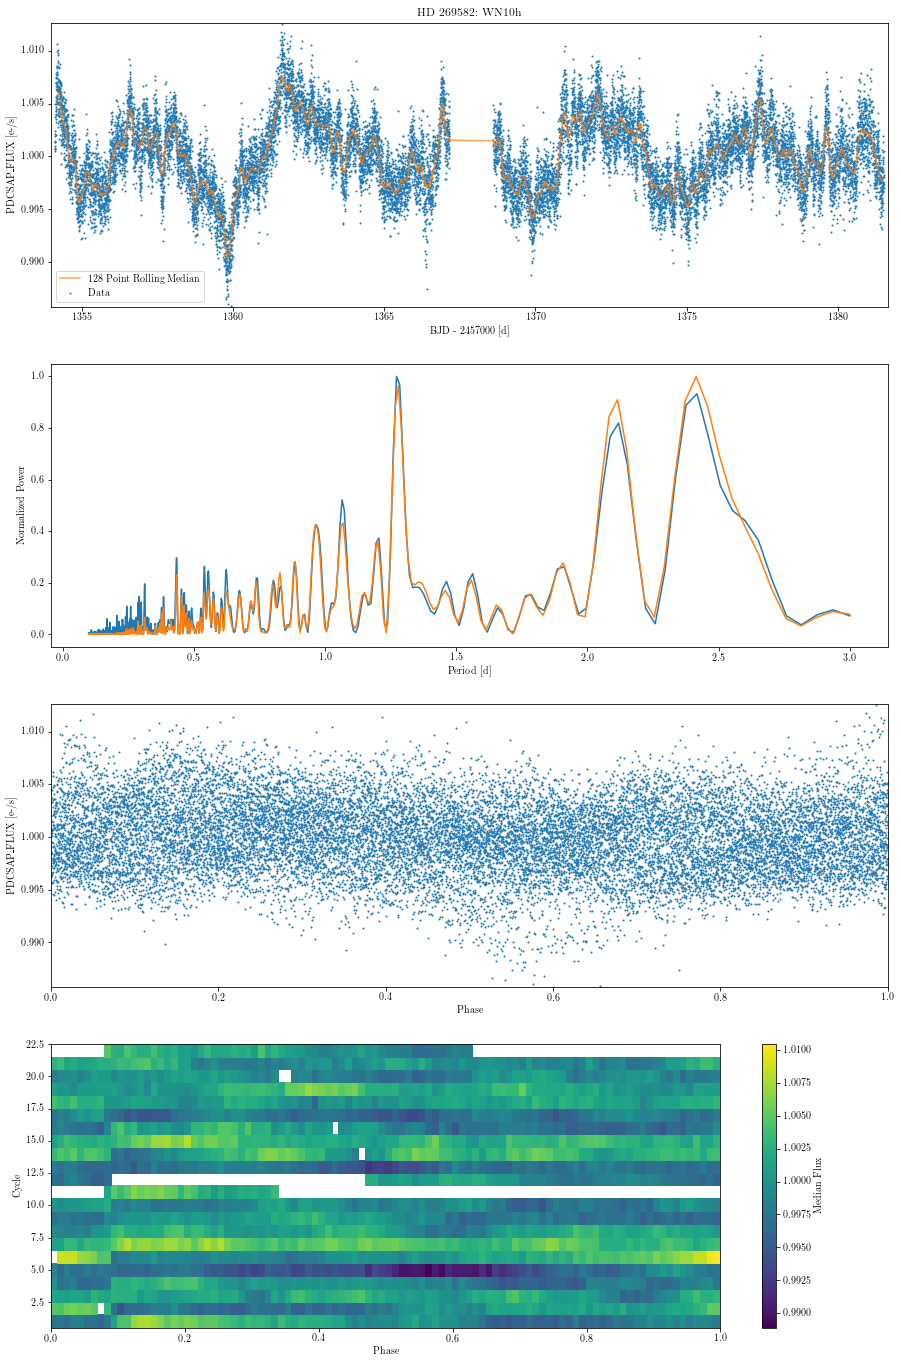

In [21]:
#HD 269582
lc = plot_lc_periodogram(279957111,phaseplot=True,dynamicplot=True,pmax=3)

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


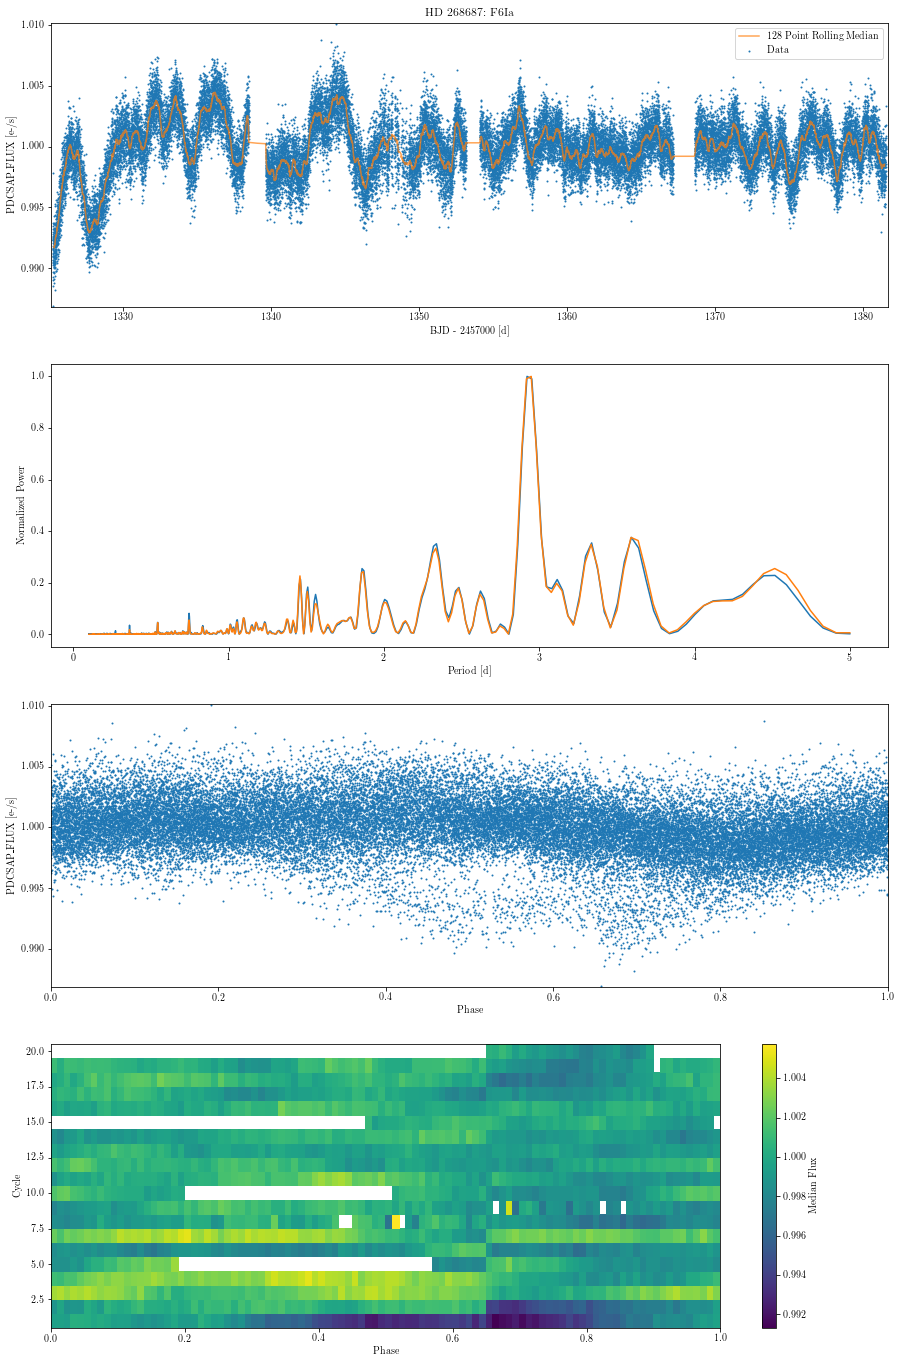

In [56]:
#HD 268687
lc = plot_lc_periodogram(29984014,phaseplot=True,dynamicplot=True,pmax=5)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [24]:
def peak_finder(f,p,n,FAL=0,width=20):
    """Given frequency/power periodogram, find the first n peaks with power greater than FAL"""
    
    assert (len(f) == len(p))&(len(f) > width),"Length of frequency array and power array much be equal, and >20"
    
    peaks = []
    strengths = []
    
    for i in range(width,len(f) - width):
        
        if np.all(p[i] > p[i -width:i])&np.all(p[i] > p[i + 1:i+width+1])&(p[i]>FAL):
            
            peaks.append(f[i])
            strengths.append(p[i])
    
    isort = np.argsort(strengths)
    peaks = np.array(peaks)[isort]
    strengths = np.array(strengths)[isort]
    return peaks[::-1][:n],strengths[::-1][:n]

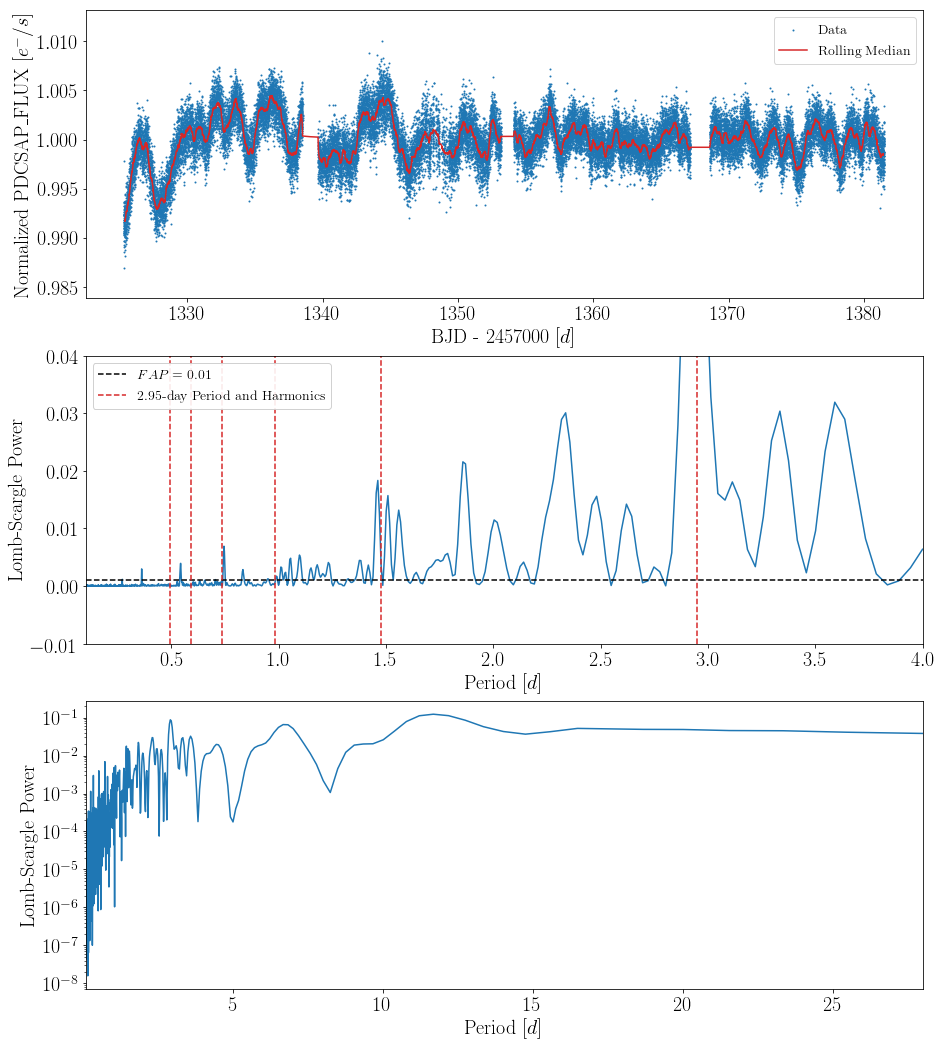

In [82]:
lc = get_lc_from_id(29984014)

rtime = lc['TIME'].values
if 'NormPDCSAP_FLUX' in lc.columns:
    rflux = lc['NormPDCSAP_FLUX'].values
else:
    rflux = lc['PDCSAP_FLUX'].values

time = rtime[~np.isnan(rflux)]
flux = rflux[~np.isnan(rflux)]

fig, ax = plt.subplots(3, figsize=(15,18))

lc_df = pd.DataFrame(data={'Time':time,'Flux':flux}).sort_values('Time')
lc_df_smooth = lc_df.rolling(128, center=True).median()

ax[0].scatter(lc_df['Time'], lc_df['Flux'], s=1, label='Data')
ax[0].plot(lc_df_smooth['Time'], lc_df_smooth['Flux'], c='C3', label='Rolling Median')
ax[0].set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

ls = LombScargle(time, flux)
f, p = ls.autopower(minimum_frequency=1.0/28.0,
                    maximum_frequency=1.0/0.1)

ax[2].plot(1.0/f,p)
ax[2].set(xlabel='Period [$d$]', ylabel='Lomb-Scargle Power', yscale='log', xlim=(0.1,28.0))

f, p = ls.autopower(minimum_frequency=1.0/4.0,
                    maximum_frequency=1.0/0.1)

fs, ps = peak_finder(f, p, 10, width=10)

dom = fs[np.argmax(ps)]
dp = 1.0/dom

FAL = ls.false_alarm_level(0.01)

ax[1].plot(1.0/f,p)
ax[1].axhline(y=FAL, ls='--', c='k', label='$FAP=0.01$')
ax[1].axvline(x=1.0/dom, ls='--', c='C3')
ax[1].axvline(x=1.0/(2.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(3.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(4.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(5.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(6.0*dom), ls='--', c='C3', label='2.95-day Period and Harmonics')
ax[1].legend(loc=2, framealpha=0.9, prop={'size': 14})
ax[1].set(xlabel='Period [$d$]', ylabel='Lomb-Scargle Power', xlim=(0.1,4), ylim=(-0.01,0.04));

for a in ax:
    for item in ([a.xaxis.label, a.yaxis.label] + a.get_xticklabels() + a.get_yticklabels()):
        item.set_fontsize(20)
        
plt.savefig('HD268687_lcperiodogram.pdf')

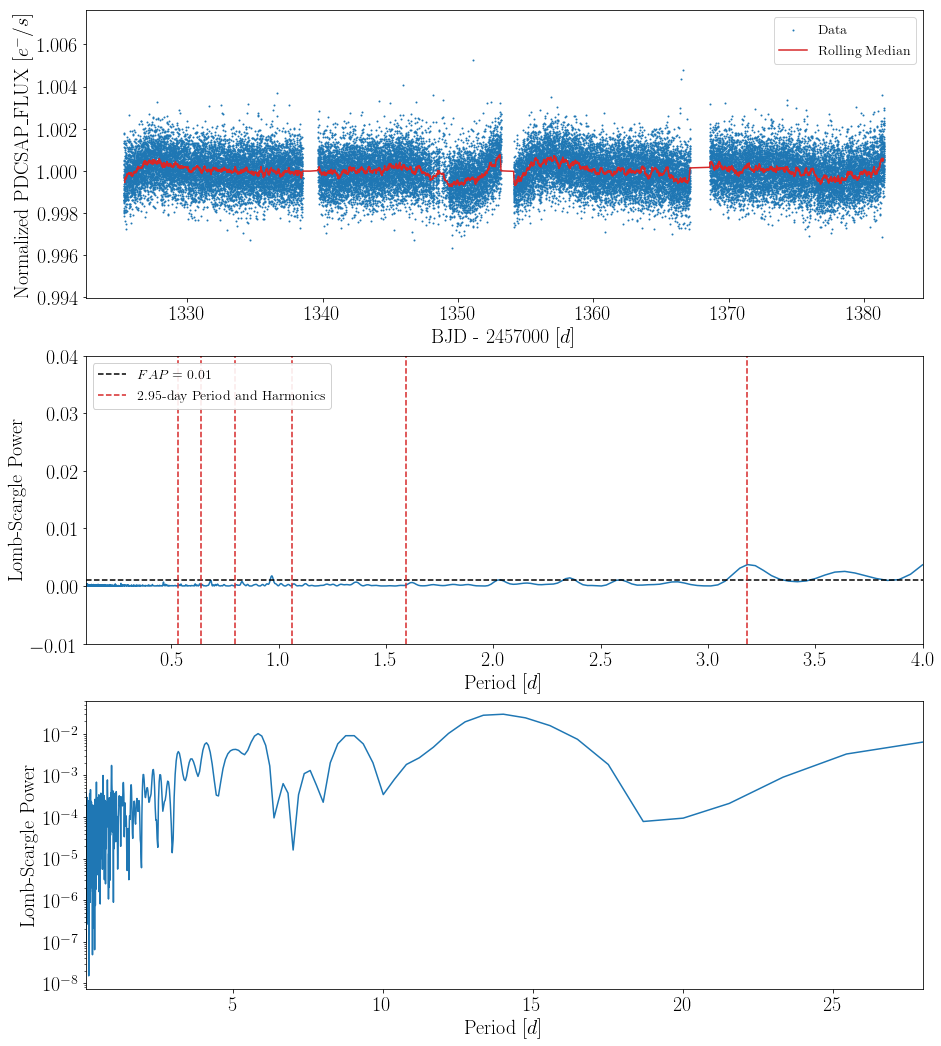

In [83]:
lc = get_lc_from_id(389437365)

rtime = lc['TIME'].values
if 'NormPDCSAP_FLUX' in lc.columns:
    rflux = lc['NormPDCSAP_FLUX'].values
else:
    rflux = lc['PDCSAP_FLUX'].values

time = rtime[~np.isnan(rflux)]
flux = rflux[~np.isnan(rflux)]

fig, ax = plt.subplots(3, figsize=(15,18))

lc_df = pd.DataFrame(data={'Time':time,'Flux':flux}).sort_values('Time')
lc_df_smooth = lc_df.rolling(128, center=True).median()

ax[0].scatter(lc_df['Time'], lc_df['Flux'], s=1, label='Data')
ax[0].plot(lc_df_smooth['Time'], lc_df_smooth['Flux'], c='C3', label='Rolling Median')
ax[0].set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

ls = LombScargle(time, flux)
f, p = ls.autopower(minimum_frequency=1.0/28.0,
                    maximum_frequency=1.0/0.1)

ax[2].plot(1.0/f,p)
ax[2].set(xlabel='Period [$d$]', ylabel='Lomb-Scargle Power', yscale='log', xlim=(0.1,28.0))

f, p = ls.autopower(minimum_frequency=1.0/4.0,
                    maximum_frequency=1.0/0.1)

fs, ps = peak_finder(f, p, 10, width=10)

dom = fs[np.argmax(ps)]
dp = 1.0/dom

FAL = ls.false_alarm_level(0.01)

ax[1].plot(1.0/f,p)
ax[1].axhline(y=FAL, ls='--', c='k', label='$FAP=0.01$')
ax[1].axvline(x=1.0/dom, ls='--', c='C3')
ax[1].axvline(x=1.0/(2.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(3.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(4.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(5.0*dom), ls='--', c='C3')
ax[1].axvline(x=1.0/(6.0*dom), ls='--', c='C3', label='2.95-day Period and Harmonics')
ax[1].legend(loc=2, framealpha=0.9, prop={'size': 14})
ax[1].set(xlabel='Period [$d$]', ylabel='Lomb-Scargle Power', xlim=(0.1,4), ylim=(-0.01,0.04));

for a in ax:
    for item in ([a.xaxis.label, a.yaxis.label] + a.get_xticklabels() + a.get_yticklabels()):
        item.set_fontsize(20)
        